In [55]:
# Data Processing Libraries
import pandas as pd
import os
import csv
import numpy as np
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt

# Model Libraries 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.keras import regularizers

### Load Model Data 
Checkpoint: Load cached data here

In [56]:
# Test Loading Data
model_data_df = pickle.load(open('../data/model_data.pkl', 'rb'))
model_data_df

,race,sample_data,label
0,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
1,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Metaplastic carcinoma, NOS"
2,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
3,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
4,white,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
...,...,...,...
1495,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1496,not reported,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1497,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"
1498,black or african american,"[[0.0, 0.0010240421486530794, 1.0, 0.0, 0.0, 0...","Infiltrating duct carcinoma, NOS"


### Preprocess Data

In [57]:
# ONE HOT ENCODE DATA
encoded_labels = pd.get_dummies(model_data_df.label)
encoded_df = model_data_df.join(encoded_labels)


In [58]:
# Filter Data Frames by Race 
white_df = encoded_df[encoded_df["race"] == "white"]
black_df = encoded_df[encoded_df["race"] == "black or african american"]
asian_df = encoded_df[encoded_df["race"] == "asian"]
prognosis_names = encoded_df.label.unique()

# Train Test Split
def df_split(df): 
    split_index = int(0.7 * len(df)) 
    return df.iloc[:split_index], df.iloc[split_index:]

train_white_df, test_white_df = df_split(white_df) 
train_black_df, test_black_df = df_split(black_df) 
train_asian_df, test_asian_df = df_split(asian_df)

# Concatenate Final Sets 
train_df = train_white_df
# train_df = pd.concat([train_white_df, train_black_df, train_asian_df])

In [77]:
# PLOT MODEL PROGRESS
def plot_history(history, history_continued, tl_epoch): 
    # Get training history
    training_loss = history.history['loss'] + history_continued.history['loss']
    training_accuracy = history.history['accuracy'] + history_continued.history['accuracy']
    val_loss = history.history['val_loss'] + history_continued.history['val_loss']
    val_accuracy = history.history['val_accuracy'] + history_continued.history['val_accuracy']
    epochs = range(1, len(training_loss) + 1)

    # Plotting loss
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, training_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.axvline(x = tl_epoch, color = 'gray', label = 'transferred', linestyle='dotted')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.ylim(0, 1) 
    plt.plot(epochs, training_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.axvline(x = tl_epoch, color = 'gray', label = 'transferred', linestyle='dotted')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

### DEFINE MODEL AND PREPARE DATA

In [59]:
# Prepare Model Data --> [takes 2 min.]
pca = PCA(n_components=25) 
prognosis_names = encoded_df.label.unique()

def get_x_y(df): 
    x = np.array([pca.fit_transform(np.transpose(data)) for data in df.sample_data.values]) # shrink to 26 values
    y = df.filter(prognosis_names).values
    return x, y

def train_val_split(data):
    # returns: x_train, x_val, y_train, y_val
    x, y = data
    return train_test_split(x, y, test_size=0.15, random_state=42)


##### Main Code #########
x_train, x_val, y_train, y_val = train_val_split(get_x_y(train_df)) # training data

x_train_black, y_train_black = get_x_y(train_black_df)
x_train_asian, y_train_asian = get_x_y(train_asian_df)

x_test_white, y_test_white = get_x_y(test_white_df)
x_test_black, y_test_black = get_x_y(test_black_df)
x_test_asian, y_test_asian = get_x_y(test_asian_df)

In [61]:
# DEFINE MODEL

# Creating an LSTM model 
model = Sequential()
model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2])))  # Adjust the units as needed
model.add(Dense(23, activation='softmax'))  # Output layer with 23 classes and softmax activation

# Freeze Model Function 
def freeze_model(model): 
    model.trainable = False 
    model.layers[-1].trainable = True
    return model 


### Model Results for Freezing Last Layer

In [79]:
### RESULTS FOR BLACK / AA Patients 

# Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=8, batch_size=32, validation_data=(x_val, y_val))

# Freeze model 
model = freeze_model(model)

# Transfer Learning 
print("---------------------- TRANSFER TO BLACK + AA DATA ----------------------")
history_continued = model.fit(x_train_black, y_train_black, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/8
19/19 [==============================] - 4s 47ms/step - loss: 0.4781 - accuracy: 0.8505 - val_loss: 1.2640 - val_accuracy: 0.5981
Epoch 2/8
19/19 [==============================] - 0s 16ms/step - loss: 0.3227 - accuracy: 0.9020 - val_loss: 1.2568 - val_accuracy: 0.5794
Epoch 3/8
19/19 [==============================] - 0s 14ms/step - loss: 0.2806 - accuracy: 0.9153 - val_loss: 1.2924 - val_accuracy: 0.5888
Epoch 4/8
19/19 [==============================] - 0s 13ms/step - loss: 0.2641 - accuracy: 0.9186 - val_loss: 1.3429 - val_accuracy: 0.5701
Epoch 5/8
19/19 [==============================] - 0s 15ms/step - loss: 0.2620 - accuracy: 0.9236 - val_loss: 1.3144 - val_accuracy: 0.5794
Epoch 6/8
19/19 [==============================] - 0s 13ms/step - loss: 0.2470 - accuracy: 0.9286 - val_loss: 1.4066 - val_accuracy: 0.5701
Epoch 7/8
19/19 [==============================] - 0s 13ms/step - loss: 0.2203 - accuracy: 0.9

In [80]:
# Check Test Performance - Black & AA Patients
evaluation = model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 10ms/step - loss: 1.1997 - accuracy: 0.7949
Performance on Black Patients
----------------------------------
Loss on test data: 1.1997438669204712
Accuracy on test data: 0.7948718070983887


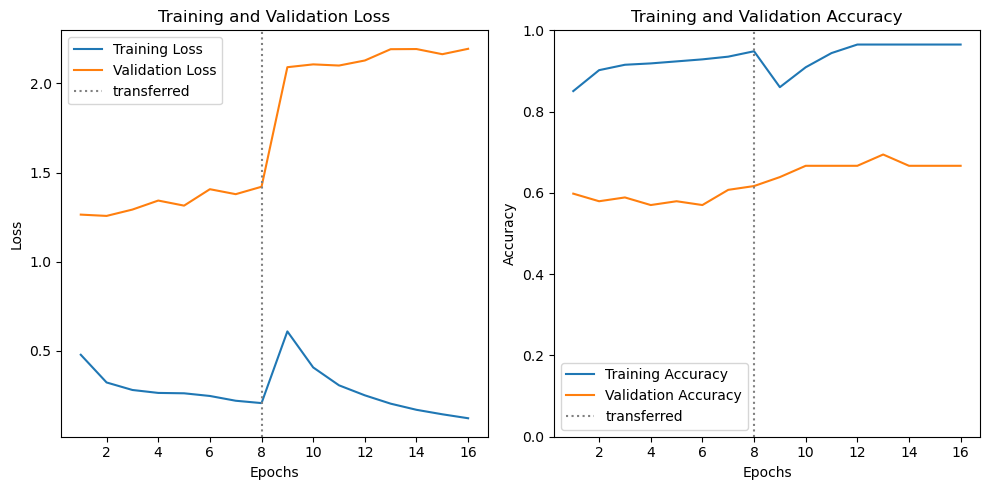

In [81]:
# PLOT MODEL PROGRESS
plot_history(history, history_continued, 8)

In [82]:
### RESULTS FOR Asian Patients 

# Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=8, batch_size=32, validation_data=(x_val, y_val))

# Freeze model 
model = freeze_model(model)

# Transfer Learning 
print("---------------------- TRANSFER TO ASAN DATA ----------------------")
history_continued = model.fit(x_train_asian, y_train_asian, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/8
19/19 [==============================] - 3s 45ms/step - loss: 0.3940 - accuracy: 0.8837 - val_loss: 1.3969 - val_accuracy: 0.5981
Epoch 2/8
19/19 [==============================] - 0s 14ms/step - loss: 0.2322 - accuracy: 0.9352 - val_loss: 1.3588 - val_accuracy: 0.5888
Epoch 3/8
19/19 [==============================] - 0s 14ms/step - loss: 0.2011 - accuracy: 0.9452 - val_loss: 1.3680 - val_accuracy: 0.6355
Epoch 4/8
19/19 [==============================] - 0s 15ms/step - loss: 0.1881 - accuracy: 0.9485 - val_loss: 1.3919 - val_accuracy: 0.6075
Epoch 5/8
19/19 [==============================] - 0s 15ms/step - loss: 0.1728 - accuracy: 0.9568 - val_loss: 1.4300 - val_accuracy: 0.6075
Epoch 6/8
19/19 [==============================] - 0s 15ms/step - loss: 0.1640 - accuracy: 0.9585 - val_loss: 1.4679 - val_accuracy: 0.6075
Epoch 7/8
19/19 [==============================] - 0s 15ms/step - loss: 0.1568 - accuracy: 0.9

In [83]:
# Check Test Performance - Asian Patients
evaluation = model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 34ms/step - loss: 1.1229 - accuracy: 0.7857
Performance on Asian Patients
----------------------------------
Loss on test data: 1.122894287109375
Accuracy on test data: 0.7857142686843872


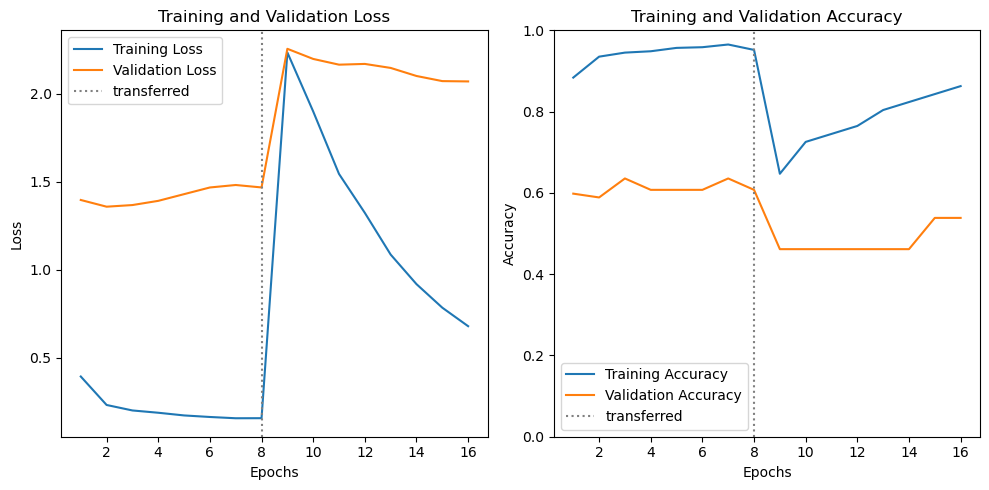

In [84]:
# PLOT MODEL PROGRESS
plot_history(history, history_continued, 8)

### Model Results for just Fine Tuning

In [85]:
### RESULTS FOR BLACK / AA Patients 

# Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=8, batch_size=32, validation_data=(x_val, y_val))

# Transfer Learning 
print("---------------------- TRANSFER TO BLACK + AA DATA ----------------------")
history_continued = model.fit(x_train_black, y_train_black, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/8
19/19 [==============================] - 3s 48ms/step - loss: 0.3287 - accuracy: 0.9003 - val_loss: 1.4516 - val_accuracy: 0.5981
Epoch 2/8
19/19 [==============================] - 0s 14ms/step - loss: 0.1863 - accuracy: 0.9485 - val_loss: 1.3988 - val_accuracy: 0.6168
Epoch 3/8
19/19 [==============================] - 0s 14ms/step - loss: 0.1561 - accuracy: 0.9601 - val_loss: 1.4333 - val_accuracy: 0.6168
Epoch 4/8
19/19 [==============================] - 0s 13ms/step - loss: 0.1393 - accuracy: 0.9601 - val_loss: 1.4927 - val_accuracy: 0.6075
Epoch 5/8
19/19 [==============================] - 0s 16ms/step - loss: 0.1308 - accuracy: 0.9651 - val_loss: 1.4985 - val_accuracy: 0.6168
Epoch 6/8
19/19 [==============================] - 0s 14ms/step - loss: 0.1422 - accuracy: 0.9601 - val_loss: 1.6553 - val_accuracy: 0.5701
Epoch 7/8
19/19 [==============================] - 0s 14ms/step - loss: 0.1413 - accuracy: 0.9

In [86]:
# Check Test Performance - Black & AA Patients
evaluation = model.evaluate(x_test_black, y_test_black)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Black Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


3/3 [==============================] - 0s 11ms/step - loss: 1.3682 - accuracy: 0.8077
Performance on Black Patients
----------------------------------
Loss on test data: 1.3682140111923218
Accuracy on test data: 0.807692289352417


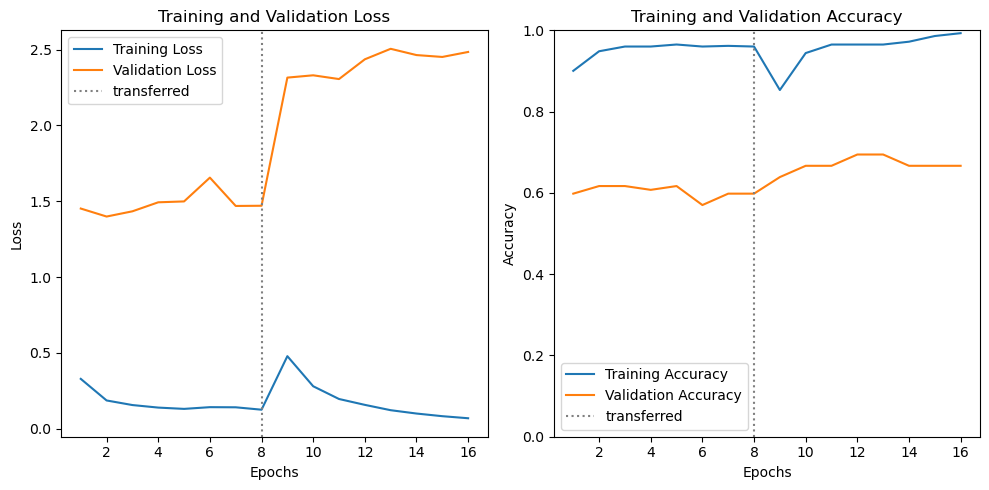

In [87]:
# PLOT MODEL PROGRESS
plot_history(history, history_continued, 8)

In [88]:
### RESULTS FOR Asian Patients 

# Compile the model
model.trainable = True
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Initial Model 
print("---------------------- TRAIN ON WHITE DATA ----------------------")
history = model.fit(x_train, y_train, epochs=8, batch_size=32, validation_data=(x_val, y_val))


# Transfer Learning 
print("---------------------- TRANSFER TO ASAN DATA ----------------------")
history_continued = model.fit(x_train_asian, y_train_asian, epochs=15, initial_epoch=history.epoch[-1], batch_size=32, validation_split=0.2)

---------------------- TRAIN ON WHITE DATA ----------------------
Epoch 1/8
19/19 [==============================] - 4s 45ms/step - loss: 0.2782 - accuracy: 0.9086 - val_loss: 1.4855 - val_accuracy: 0.6355
Epoch 2/8
19/19 [==============================] - 0s 13ms/step - loss: 0.1417 - accuracy: 0.9635 - val_loss: 1.5146 - val_accuracy: 0.6262
Epoch 3/8
19/19 [==============================] - 0s 12ms/step - loss: 0.1239 - accuracy: 0.9635 - val_loss: 1.5060 - val_accuracy: 0.6075
Epoch 4/8
19/19 [==============================] - 0s 13ms/step - loss: 0.1144 - accuracy: 0.9651 - val_loss: 1.5189 - val_accuracy: 0.5981
Epoch 5/8
19/19 [==============================] - 0s 13ms/step - loss: 0.1078 - accuracy: 0.9718 - val_loss: 1.5927 - val_accuracy: 0.6262
Epoch 6/8
19/19 [==============================] - 0s 15ms/step - loss: 0.1096 - accuracy: 0.9684 - val_loss: 1.5480 - val_accuracy: 0.5888
Epoch 7/8
19/19 [==============================] - 0s 13ms/step - loss: 0.1051 - accuracy: 0.9

In [89]:
# Check Test Performance - Asian Patients
evaluation = model.evaluate(x_test_asian, y_test_asian)

# 'evaluation' will contain the loss value and accuracy
loss = evaluation[0]
accuracy = evaluation[1]

print("Performance on Asian Patients")
print("----------------------------------")
print(f"Loss on test data: {loss}")
print(f"Accuracy on test data: {accuracy}")


1/1 [==============================] - 0s 54ms/step - loss: 1.2992 - accuracy: 0.6786
Performance on Asian Patients
----------------------------------
Loss on test data: 1.2991873025894165
Accuracy on test data: 0.6785714030265808


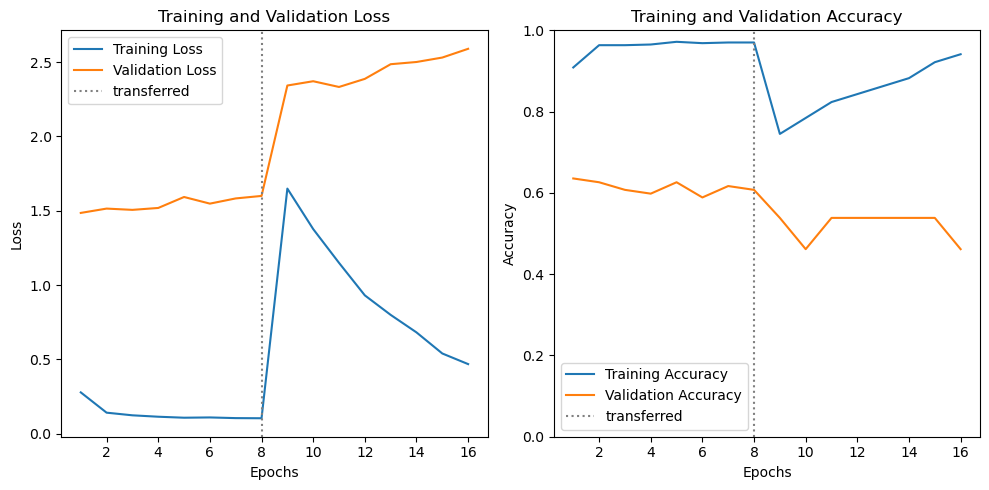

In [90]:
# PLOT MODEL PROGRESS
plot_history(history, history_continued, 8)